In [50]:
# Essentials 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re 

# EFA
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# SEM
from semopy import Model, calc_stats



In [51]:
# ===============================================
# EFA on 15 subscales + plots + OLS
# ===============================================


# ---------------------------
# CONFIG — update path ONLY
# ---------------------------
CSV_PATH = "final_final_allsubj_personality_coded.csv"   # <-- your CSV file here
ID_COL   = None                          # or "Subject_ID" if present
MAX_MISSING_ROW_FRAC = 0.2               # drop rows with >20% missing subscales
RANDOM_STATE = 42
PARALLEL_N_ITER = 500                    # more iters = smoother parallel analysis

np.random.seed(RANDOM_STATE)

# ------------------------------------
# 1) Load CSV and select these columns
# ------------------------------------
# Drop columns as needed for factor analysis & SEM 

all_cols = [
    "BFI_O","BFI_C","BFI_E","BFI_A", "BFI_N",
    "IUS_Total","NFC_Total",
    "IRI_PT","IRI_FS","IRI_EC","IRI_PD",
    "PANAS_PA","PANAS_NA", "SVS_Openness", "SVS_Conservation"   
    ]

cols_expected = [
    "BFI_O","BFI_C","BFI_E","BFI_A", "BFI_N",
    "IUS_Total","NFC_Total",
    "IRI_PT","IRI_FS","IRI_EC","IRI_PD",
    "PANAS_PA","PANAS_NA", "SVS_Openness", "SVS_Conservation"   
    ]

dropped_cols = []


    
df_raw = pd.read_csv(CSV_PATH, dtype=str)
print("Columns in df_raw:", df_raw.columns.tolist())

missing = [c for c in cols_expected if c not in df_raw.columns]
if missing:
    raise ValueError(f"Missing expected columns in CSV: {missing}")



Columns in df_raw: ['sub#', 'A1.我想我自己是健談的', 'A2.我想我自己是傾向挑人毛病', 'A3. 我想我自己是會貫徹始終把事情做完', 'A4.我想我自己是憂鬱的', 'A5.我想我自己是會創新、有新想法', 'A6.我想我自己是沉默寡言', 'A7.我想我自己是樂於助人且無私的', 'A8.我想我自己是有點粗心', 'A9.我想我自己是放鬆的，善於處理壓力', 'A10.我想我自己是會對許多不同事物感到好奇', 'A11.我想我自己是充滿活力', 'A12.我想我自己是會開啟與他人的爭執', 'A13.我想我自己是可信賴的工作者', 'A14.我想我自己是緊張的', 'A15.我想我自己是聰明的、會深思的人', 'A16.我想我自己是有非常多熱情', 'A17.我想我自己是有寬容本質', 'A18.我想我自己是較沒有條理組織的', 'A19.我想我自己是擔心很多的', 'A20.我想我自己是具有生動想像力', 'A21.我想我自己是較安靜的', 'A22.我想我自己是通常容易信賴他人', 'A23.我想我自己是較懶散的', 'A24.我想我自己是情緒上穩定、不容易煩躁', 'A25.我想我自己是有創造力的', 'A26.我想我自己是有果決個性的', 'A27.我想我自己是對他人冷漠及疏離的', 'A28.我想我自己是會堅持到工作完成', 'A29.我想我自己是情緒不穩定的', 'A30.我想我自己是重視藝術及美學經驗', 'A31.我想我自己是有時會害羞、退縮的', 'A32.我想我自己是幾乎對所有人體貼且仁慈的', 'A33.我想我自己是做事有效率的', 'A34.我想我自己是在緊張情境也能保持冷靜', 'A35.我想我自己是偏好例行性工作', 'A36.我想我自己是喜歡外出、好社交的', 'A37.我想我自己是有時會粗魯對待他人', 'A38.我想我自己是會訂計畫並依計畫執行', 'A39.我想我自己是容易感到緊張的', 'A40.我想我自己是喜歡思考、常有想法', 'A41.我想我自己是對於藝術興趣很低', 'A42.我想我自己是喜歡與他人合作', 'A43.我想我自己是易於分心的', 'A44.我想我自己是懂得藝術、音樂和文學', 'BFI_O', 'BFI_C', 'BFI_E', 'BFI_A', 'BFI_N',

In [52]:
CSV_PATH_2 = 'allsubj_personality(2).xlsx'
worksheet = pd.read_excel(CSV_PATH_2, sheet_name='工作表1')
opposing_update_one = worksheet.loc[0:44, '1stUpdated']
opposing_update_two = worksheet.loc[45:86, '2ndUpdate']
opposing_update = pd.concat([opposing_update_one, opposing_update_two], ignore_index=True)
supporting_update_one = worksheet.loc[0:44, '2ndUpdate']
supporting_update_two = worksheet.loc[45:86, '1stUpdated']
supporting_update = pd.concat([supporting_update_one, supporting_update_two], ignore_index=True)
opposing_update = pd.Series(opposing_update)
supporting_update = pd.Series(supporting_update)

# opposing_update: series of belief change after seeing opposed videos
# supporting_update: same but for supporting videos

In [53]:

# Pre processing
def pre_processing(subs):
    # ------------------------------------
    # 2) Missing data handling & z-scoring
    # ------------------------------------
    row_missing = subs.isna().mean(axis=1)
    keep = row_missing <= MAX_MISSING_ROW_FRAC
    if (~keep).sum():
        print(f"Dropping {(~keep).sum()} rows (> {int(MAX_MISSING_ROW_FRAC*100)}% missing subscales)")
    subs = subs.loc[keep].copy()

    # mean-impute then z-score
    subs = subs.apply(pd.to_numeric, errors='coerce')  # convert all columns to numeric, set errors to NaN
    subs = subs.apply(lambda s: s.fillna(s.mean()), axis=0)
    subs_z = (subs - subs.mean()) / subs.std(ddof=0)




    # ------------------------------------------------
    # 3) Factorability checks: Bartlett & KMO (sanity)
    #------------------------------------------------

    bart_chi2, bart_p = calculate_bartlett_sphericity(subs_z)
    kmo_per_item, kmo_overall = calculate_kmo(subs_z)
    print(f"Bartlett’s χ²={bart_chi2:.1f}, p={bart_p:.3g} (want p<.05)")
    print(f"KMO overall={kmo_overall:.3f} (>.60 acceptable; >.80 great)")
    subs_z.head()
    return subs_z

In [54]:

def factor_analysis(subs_z):
    # ------------------------------------------------
    # 4) Choose number   of factors: Scree + Parallel
    # ------------------------------------------------
    fa_tmp = FactorAnalyzer(rotation=None, method="ml")
    fa_tmp.fit(subs_z)
    ev, _ = fa_tmp.get_eigenvalues()

    plt.figure(figsize=(7,4))
    plt.plot(range(1, len(ev)+1), ev, marker='o')
    plt.axhline(1, color='r', ls='--')
    plt.title("Scree Plot (Eigenvalues)")
    plt.xlabel("Factor")
    plt.ylabel("Eigenvalue")
    plt.tight_layout()
    #plt.show()

    def parallel_analysis_eigs(df, n_iter=500, random_state=42):
        rng = np.random.default_rng(random_state)
        n, p = df.shape
        obs_corr = np.corrcoef(df, rowvar=False)
        obs_eigs = np.linalg.eigvalsh(obs_corr)[::-1]
        rand_eigs = []
        for _ in range(n_iter):
            rand = rng.standard_normal(size=(n, p))
            rand_corr = np.corrcoef(rand, rowvar=False)
            rand_eigs.append(np.linalg.eigvalsh(rand_corr)[::-1])
        rand_eigs = np.vstack(rand_eigs)
        perc95 = np.percentile(rand_eigs, 95, axis=0)
        return obs_eigs, perc95

    obs_eigs, perc95 = parallel_analysis_eigs(subs_z, n_iter=PARALLEL_N_ITER, random_state=RANDOM_STATE)
    n_pa = int((obs_eigs > perc95).sum())
    n_kaiser = int((obs_eigs > 1.0).sum())
    n_factors = n_pa if n_pa > 0 else max(1, n_kaiser)
    #print(f"Parallel analysis suggests {n_pa} factors; Kaiser>1 suggests {n_kaiser}. → Using n_factors={n_factors}")
    if n_factors != 4:
        print(f"Parallel analysis suggests {n_pa} factors; Kaiser>1 suggests {n_kaiser}. → Using n_factors={n_factors}")

    plt.figure(figsize=(7,4))
    plt.plot(range(1, len(obs_eigs)+1), obs_eigs, marker='o', label='Observed')
    plt.plot(range(1, len(perc95)+1), perc95, marker='x', label='95% random')
    plt.title("Parallel Analysis")
    plt.xlabel("Factor")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.tight_layout()
    #plt.show()

    # ---------------------------------------
    # 5) EFA (ML + oblimin) on these vars
    # ---------------------------------------
    fa = FactorAnalyzer(n_factors=n_factors, rotation="oblimin", method="ml")
    fa.fit(subs_z)

    loadings = pd.DataFrame(
        fa.loadings_, index=subs_z.columns,
        columns=[f"Factor{i+1}" for i in range(n_factors)]
    )

    # --------------------------------------------------------------
    # 6) Paper-style grouped bar plot for any factor (like the paper)
    # --------------------------------------------------------------
    def which_group(var):
        if var.startswith("BFI_"):   return "BFI"
        if var.startswith("IUS_"):   return "IUS"
        if var.startswith("NFC_"):   return "NFC"
        if var.startswith("IRI_"):   return "IRI"
        if var.startswith("PANAS_"): return "PANAS"
        if var.startswith("SVS_"):   return "SVS"
        return "Other"

    palette = {
        'BFI':'#999999',   # gray
        'IUS':'#E69F00',   # orange
        'NFC':'#56B4E9',   # blue
        'IRI':'#009E73',   # green
        'PANAS':'#F0E442', # yellow
        'SVS':'#0072B2',   # dark blue
        'Other':'#CC79A7'  # magenta
    }

    def plot_factor_bar(loadings_df, factor_name='Factor1', title='Factor 1'):

        df = loadings_df[[factor_name]].copy()
        df['var']   = df.index
        df['group'] = df['var'].map(which_group)
        # group order by first appearance in your column list:
        order_first = df.groupby('group').apply(lambda g: cols_expected.index(g['var'].iloc[0]) if g['var'].iloc[0] in cols_expected else 999)
        group_order = list(order_first.sort_values().index)
        # keep original subscale order within each group (based on cols_expected)
        orig_pos = {v:i for i,v in enumerate(cols_expected)}
        df['orig'] = df['var'].map(orig_pos)
        df['group_cat'] = pd.Categorical(df['group'], categories=group_order, ordered=True)
        df = df.sort_values(['group_cat','orig'])

        x = np.arange(len(df))
        y = df[factor_name].values
        colors = [palette.get(g,'#999999') for g in df['group']]

        plt.figure(figsize=(12, 3.6))
        plt.bar(x, y, color=colors, width=0.9)
        plt.axhline(0, color='black', lw=1)
        plt.ylabel("Loadings")
        plt.title(title, loc='left')
        plt.xticks([], [])  # hide tick labels

        handles = [mpatches.Patch(color=palette[g], label=g) for g in group_order]
        plt.legend(handles=handles, title="Questionnaires",
                bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)
        plt.tight_layout()
        #plt.show()
        

    # Example: plot for Factor 1 (rename once you interpret it)
    #plot_factor_bar(loadings, 'Factor1', title='Factor 1')

    
    for k in range(n_factors): 
        plot_factor_bar(loadings, f'Factor{k+1}', title=f'Factor {k+1}')

    # plot_factor_bar(loadings, 'Factor2', group_map=group_map, group_order=group_order, title='Factor 2: …')
    # plot_factor_bar(loadings, 'Factor3', group_map=group_map, group_order=group_order, title='Factor 3: …')

    # ---------------------------------------
    # 7) Factor scores (z) for each participant
    # ---------------------------------------
    factor_scores = pd.DataFrame(
        fa.transform(subs_z),
        columns=[f"Factor{i+1}" for i in range(n_factors)],
        index=subs_z.index
    )
    factor_scores = (factor_scores - factor_scores.mean()) / factor_scores.std(ddof=0)

    # optional save
    out = factor_scores.copy()
    if ID_COL and ID_COL in df_raw.columns:
        out.insert(0, ID_COL, df_raw.loc[subs_z.index, ID_COL].values)
    out.to_csv("factor_scores_15subscales.csv", index=False)
    print("Saved factor scores → factor_scores_15subscales.csv")

    # ----------------------------------------------------
    # 8) Outcome: Belief change (existing or pre/post diff)
    # ----------------------------------------------------
    df_work = df_raw.loc[subs_z.index].copy()
    return loadings, n_factors
    

In [55]:

# Load the wide-format loadings
def generate_semopy_syntax(loadings):
    loadings_df = loadings.copy()

    # Melt to long format
    long_loadings = loadings_df.reset_index().melt(id_vars='index', var_name='latent', value_name='loading')
    long_loadings = long_loadings.rename(columns={'index': 'indicator'})

    # Build measurement model lines (fixed loadings)
    measurement_lines = []
    for latent in long_loadings['latent'].unique():
        subset = long_loadings[long_loadings['latent'] == latent]
        # Only include nonzero loadings (optional, but usually preferred)
        indicators = [f"{row['loading']}*{row['indicator']}" for _, row in subset.iterrows() if abs(row['loading']) > 1e-6]
        line = f"{latent} =~ " + " + ".join(indicators)
        measurement_lines.append(line)

    # Print the measurement model syntax
    semopy_line = ""
    for line in measurement_lines:
        semopy_line += line + "\n"

    print(semopy_line)
    return semopy_line

In [56]:


def sem_path_analysis(semopy_line, n_factors):
    '''
    CONSTRUCTS = [
        "BFI_O","BFI_C","BFI_E","BFI_A","BFI_N",
        "NFC_Total",
        "IUS_Total",  # Originally IUS_Pros + IUS_Inhib, combined into IUS Total (change later?)
        "IRI_PT","IRI_FS","IRI_EC","IRI_PD",
        "PANAS_PA","PANAS_NA",
        "SVS_Openness","SVS_Conservation"
    ]
    
    DROPPED_CONSTRUCTS = [] 
    '''
    
    CONSTRUCTS = cols_expected
    DROPPED_CONSTRUCTS = dropped_cols


    # Outcomes (must be present)
    Y_OPPOSE  = "delta_oppose" #delta_oppose
    Y_SUPPORT = "delta_support" #delta_support
    Y_COMBINED = "Delta_all"     # will be created below

    # Flags
    STANDARDIZE_CONSTRUCTS = True
    USE_ABS_UPDATES = False      # True => |Delta_oppose|, |Delta_support| individually
    COMBINED_MODE = "mean_abs_components"  # "mean_abs_components" or abs_of_mean

    # ------------------------------------------------------------------------------------
    # 1) LOAD & PREP
    # ------------------------------------------------------------------------------------
    df = pd.read_csv(CSV_PATH)
    # rename columns to fit expected names
    df = df.rename(columns={'opposing_update': 'delta_oppose', 'supporting_update': 'delta_support'})

    # Ensure outcomes exist
    for y in [Y_OPPOSE, Y_SUPPORT]:
        if y not in df.columns:
            raise ValueError(f"Outcome column '{y}' is missing from the CSV.")
    
    # Optionally convert each update to absolute magnitude
    #if USE_ABS_UPDATES:
    #    df[Y_OPPOSE]  = df[Y_OPPOSE].abs()
    #    df[Y_SUPPORT] = df[Y_SUPPORT].abs()
    #

    # Create combined outcome
    if COMBINED_MODE == "mean_abs_components":
        # Recommended: average of magnitudes
        df[Y_OPPOSE] = pd.to_numeric(df[Y_OPPOSE], errors='coerce')
        df[Y_SUPPORT] = pd.to_numeric(df[Y_SUPPORT], errors='coerce')
        df[Y_COMBINED] = ((df[Y_OPPOSE]).abs() + (df[Y_SUPPORT]).abs()) / 2.0
    elif COMBINED_MODE == "abs_of_mean":
        # Alternative: absolute of the mean
        df[Y_COMBINED] = ((df[Y_OPPOSE] + df[Y_SUPPORT]) / 2.0).abs()
    else:
        raise ValueError("COMBINED_MODE must be 'mean_abs_components' or 'abs_of_mean'.")

    # Keep only columns we need; drop rows with missing values
    available_constructs = [c for c in CONSTRUCTS if c in df.columns and c not in DROPPED_CONSTRUCTS]
    if not available_constructs:
        raise ValueError("None of the specified CONSTRUCTS were found in the CSV.")

    use_cols = available_constructs + [Y_OPPOSE, Y_SUPPORT, Y_COMBINED]
    data = df[use_cols].dropna().copy()

    # Standardize constructs (not outcomes) for interpretability of standardized paths
    if STANDARDIZE_CONSTRUCTS:
        for c in available_constructs:
            s = data[c].std(ddof=0)
            if pd.notnull(s) and s > 0:
                data[c] = (data[c] - data[c].mean()) / s

    print(f"n (after dropna) = {len(data)}")
    print("Predictors used:", available_constructs)
    print("Combined mode:", COMBINED_MODE, "| USE_ABS_UPDATES:", USE_ABS_UPDATES)

    # ------------------------------------------------------------------------------------
    # 2) Helper: fit one SEM path model for a single outcome
    # ------------------------------------------------------------------------------------
    def fit_sem_path(data, constructs, outcome):
        """Fits a path model: outcome ~ all constructs (observed)."""
        rhs = " + ".join(constructs)
        #structural = f"{outcome} ~ Factor1 + Factor2 + Factor3 + Factor4\n"
        structural = f"{outcome} ~ Factor1"
        for n in range(2, n_factors+1):
            structural += f" + Factor{n}"

        structural += "\n"

        full_model = semopy_line + structural
        m = Model(full_model)
        m.fit(data)

        stats = calc_stats(m)
        est = m.inspect(std_est=True)

        
        # Extract and sort structural paths by absolute standardized estimate
        betas = est[(est["op"]=="~") & (est["lval"]==outcome)].copy()
        betas["abs_std"] = betas["Est. Std"].abs()
        #betas = betas.sort_values("abs_std", ascending=False)

        # Print summary
        print(f"\n=== SEM Path for {outcome} ===")
        #print({k: stats[k] for k in ["CFI","TLI","RMSEA","SRMR","AIC","BIC"]})
        #no latent variables like SRMR, so we'll just print what we have
        fit_indices = ["CFI","TLI","RMSEA","SRMR","AIC","BIC"]
        available_stats = {k: stats[k] for k in fit_indices if k in stats}

        #rmsea = float(stats["RMSEA"])
        #print(f"RMSEA = {rmsea:.3f}")
        print(f"stats: {available_stats}")
        #r2 = stats["r2"].get(outcome, np.nan)

        r2_dict = stats.get("r2", {})      # returns {} if 'r2' key is missing
        r2 = r2_dict.get(outcome, np.nan)  # returns np.nan if outcome not present
        rmsea = float(stats["RMSEA"])
        print(f"RMSEA = {rmsea:.8f}")
        
        print(f"R^2({outcome}) = {r2:.3f}")
        print("\nStandardized paths (sorted by |Std. Estimate|):")
        print(betas[["rval","Estimate","Std. Err","z-value","p-value","Est. Std"]])

        # BEGIN TEST CODE 

        # after m.fit(data) and stats = calc_stats(m)
        chi2 = stats.get("Chi-Squared", stats.get("chi2", None))
        df_ = stats.get("DoF", stats.get("df", None))
        n_obs = len(data)  # or stats.get("N", None) if available
        print("Chi2:", chi2)
        print("DoF:", df_)
        print("N (used):", n_obs)

        if chi2 is not None and df_ is not None and n_obs is not None:
            chi2_div_df = float(chi2) / float(df_)
            raw_rmsea = (chi2_div_df - 1.0) / (n_obs - 1.0)
            rmsea_manual = (raw_rmsea if raw_rmsea > 0 else 0.0) ** 0.5
            print(f"chi2/df = {chi2_div_df:.4f}, raw_rmsea = {raw_rmsea:.8e}, rmsea_manual = {rmsea_manual:.8f}")
        else:
            print("Missing chi2/df/n to compute manual RMSEA.")

        # END TEST CODE 




        #RMSEA is zero because chi-squared is smaller than degrees of freedom - not an issue
        return {"model": m, "stats": stats, "betas": betas, "r2": r2, "model_syntax": full_model}

    # ------------------------------------------------------------------------------------
    # 3) Fit THREE separate models
    # ------------------------------------------------------------------------------------
    res_opp = fit_sem_path(data, available_constructs, Y_OPPOSE)
    res_sup = fit_sem_path(data, available_constructs, Y_SUPPORT)
    res_all = fit_sem_path(data, available_constructs, Y_COMBINED)

    # ------------------------------------------------------------------------------------
    # 4) Save coefficient tables (optional)
    # ------------------------------------------------------------------------------------
    res_opp["betas"].to_csv("sem_paths_Delta_oppose.csv", index=False)
    res_sup["betas"].to_csv("sem_paths_Delta_support.csv", index=False)
    res_all["betas"].to_csv("sem_paths_Delta_all.csv", index=False)
    return res_opp, res_sup, res_all
    #print("\nSaved: sem_paths_Delta_oppose.csv / sem_paths_Delta_support.csv / sem_paths_Delta_all.csv")

    #print("Degrees of Freedom =", res_opp["stats"]["DoF"])


Bartlett’s χ²=515.4, p=1.65e-60 (want p<.05)
KMO overall=0.721 (>.60 acceptable; >.80 great)


c:\Users\27KarlC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\27KarlC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\27KarlC\AppData\Local\Temp\ipykernel_39644\1966404586.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  order_first = df.groupby('group').apply(lambda g: cols_expected.index(g['var'].iloc[0]) if g['var'].iloc[0] in cols_expected else

Parallel analysis suggests 3 factors; Kaiser>1 suggests 4. → Using n_factors=3
Saved factor scores → factor_scores_15subscales.csv

C:\Users\27KarlC\AppData\Local\Temp\ipykernel_39644\1966404586.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  order_first = df.groupby('group').apply(lambda g: cols_expected.index(g['var'].iloc[0]) if g['var'].iloc[0] in cols_expected else 999)
c:\Users\27KarlC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\27KarlC\AppData\Local\Temp\ipykernel_39644\374416850.py:118: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rmsea = f


Factor1 =~ 0.4306709483155312*BFI_O + -0.14343044480506034*BFI_C + 0.2435244159881429*BFI_E + 0.30405124263416955*BFI_A + 0.07708375842236397*BFI_N + 0.012936009804179922*IUS_Total + 0.014593381972273101*NFC_Total + 0.8659346265450305*IRI_PT + 0.925768680413778*IRI_FS + 0.7699193449833451*IRI_EC + 0.44100685342542933*IRI_PD + 0.13797768714668784*PANAS_NA + 0.3327332612612693*SVS_Openness + 0.09967773220855604*SVS_Conservation
Factor2 =~ -0.012035579394633705*BFI_O + 0.8957867043500114*BFI_C + 0.516605899939322*BFI_E + 0.6613545061838485*BFI_A + 0.5834428385452465*BFI_N + -0.09546863399757013*IUS_Total + 0.03531645982201796*NFC_Total + -0.14741107919369342*IRI_PT + 0.04551536203278533*IRI_FS + 0.11932159708207551*IRI_EC + 0.21544573848020268*IRI_PD + -0.3545828583116125*PANAS_NA + -0.048208540070171904*SVS_Openness + 0.3538582571737085*SVS_Conservation
Factor3 =~ -0.3351973298172776*BFI_O + 0.07946191641982085*BFI_C + 0.06360572522414643*BFI_E + -0.059650041433808046*BFI_A + -0.2438093

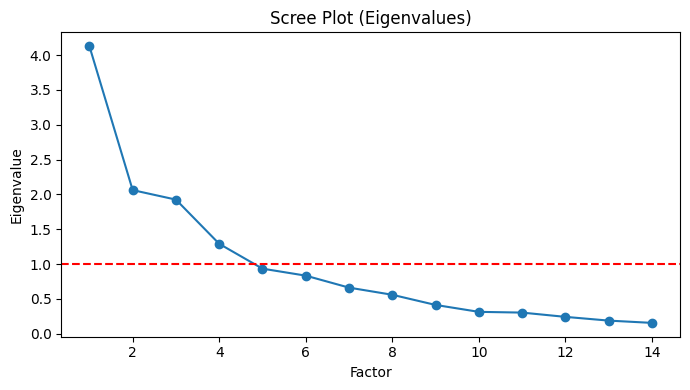

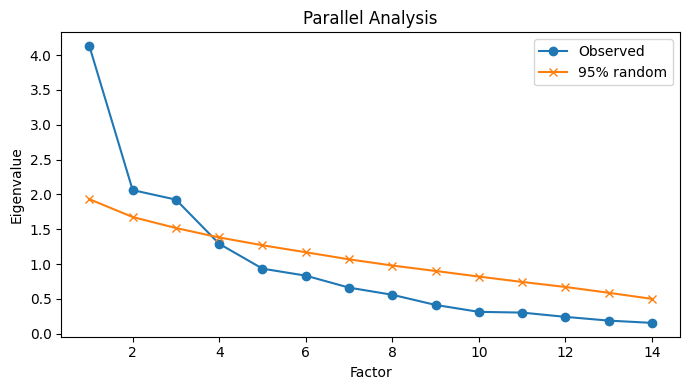

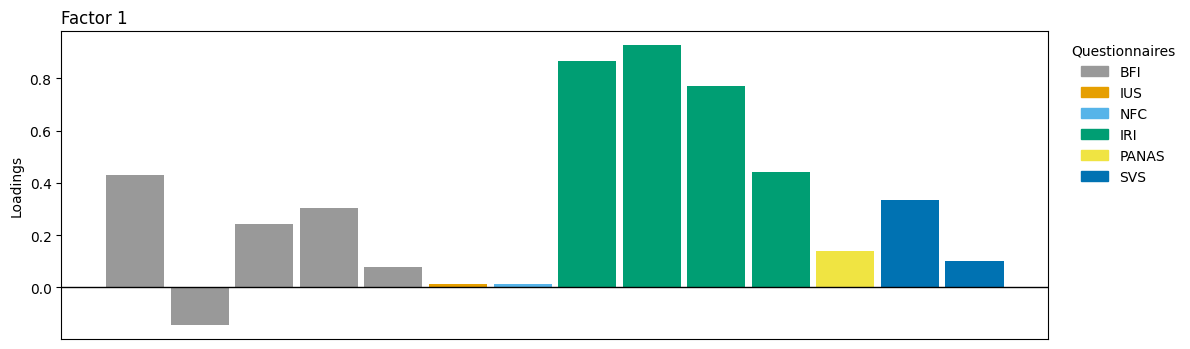

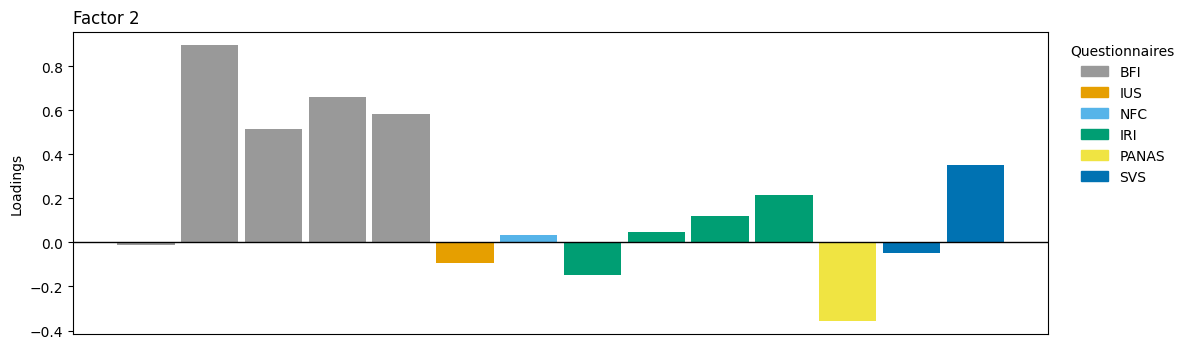

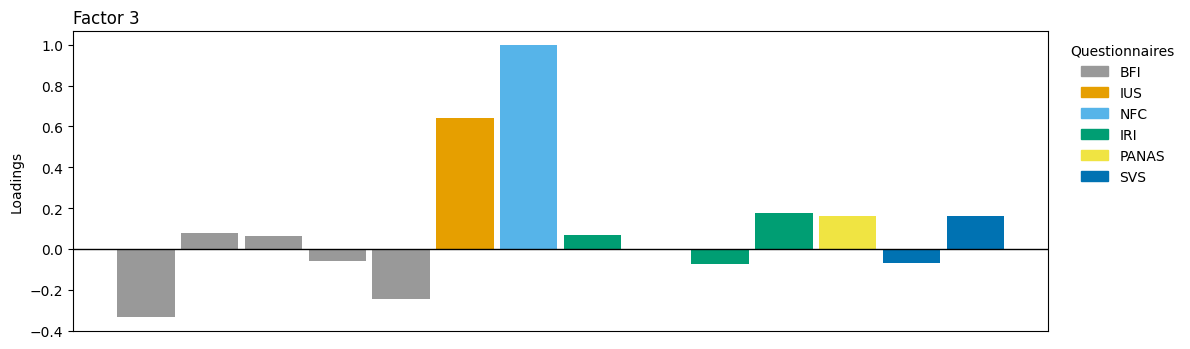

In [57]:
#For replicability - different cols dropped 
features_drop = ["PANAS_PA"]

#remember to change code --> account for a number of factors other than 4 
data_p_values = []

for i in range(1):
    data_drop = []
    dropped_feature = features_drop[i]
    cols_expected.remove(dropped_feature)

    dropped_cols = dropped_cols.copy()
    dropped_cols.append(dropped_feature)
    subs = df_raw[cols_expected].copy()

    subs_z = pre_processing(subs)
    
    loadings, n_factors = factor_analysis(subs_z)
    semopy_line = generate_semopy_syntax(loadings)
    #print(f"SEMOPYLINESEMOPYLINE:{semopy_line}")
    d_opp, d_sup, d_all = sem_path_analysis(semopy_line, n_factors)
    
    p_values = [d_opp['betas']['p-value'], d_sup['betas']['p-value'], d_all['betas']['p-value']]
    d_opp['betas']['p-value'] = d_opp['betas']['p-value'].astype(float) 
    d_sup['betas']['p-value'] = d_sup['betas']['p-value'].astype(float) 
    d_all['betas']['p-value'] = d_all['betas']['p-value'].astype(float) 
    d_opp_vals = d_opp['betas']['p-value'].tolist()
    d_sup_vals = d_sup['betas']['p-value'].tolist()
    d_all_vals = d_all['betas']['p-value'].tolist()

    data_drop.append(dropped_feature)
    data_drop.extend(d_opp_vals)
    data_drop.extend(d_sup_vals)
    data_drop.extend(d_all_vals)    
    data_p_values.append(data_drop)

    #reset list to default 
    cols_expected = all_cols.copy()
    dropped_cols = []

columns = ['Dropped Feature']
print(len(columns))

for n in range (1, n_factors + 1):
    columns.append(f'opp_factor{n}')
for n in range (1, n_factors + 1):
    columns.append(f'sup_factor{n}')
for n in range (1, n_factors + 1):
    columns.append(f'all_factor{n}')

data_p_values_df = pd.DataFrame(data_p_values, columns=columns)

data_p_values_df.to_excel('data_results_trial2.xlsx', index=False)

